# Editing Scene (Habitat-Lab 레벨 Tutorial)

Configuration

In [1]:
import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

### 1. Make object on the receptacle at the scene

In [2]:
from habitat.config.default_structured_configs import AgentConfig

# Agent config 정의
main_agent_config = AgentConfig()

urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "FetchRobot"

from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadDepthSensorConfig, HeadPanopticSensorConfig
# Agent Config 속 Sensor 정의
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
    "head_depth": HeadDepthSensorConfig(),
    "head_panoptic": HeadPanopticSensorConfig()
}

agent_dict = {"main_agent": main_agent_config}

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [3]:
import warnings
warnings.filterwarnings('ignore')
from omegaconf import OmegaConf

from habitat.config.default_structured_configs import SimulatorConfig
import habitat_sim
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim

from habitat_sim.physics import JointMotorSettings, MotionType
import magnum as mn

def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True
    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hssd-hab/scenes-partnr-filtered/102344022.scene_instance.json") # 진짜 그 scene을 정의하는 json
    sim_cfg.scene_dataset = os.path.join(data_path, "hssd-hab/hssd-hab-partnr.scene_dataset_config.json") # 이외에 scene load에 필요한 데이터셋들 경로 저장
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')] # 추가 objects 경로
    
    cfg = OmegaConf.create(sim_cfg)
    
    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    
    return cfg


def init_rearrange_sim(agent_dict):
    # Start the scene config
    sim_cfg = make_sim_cfg(agent_dict)    
    
    cfg = OmegaConf.create(sim_cfg)
    
    # Create the scene
    sim = RearrangeSim(cfg)
    
    # This is needed to initialize the agents
    sim.agents_mgr.on_new_scene()

    # For this tutorial, we will also add an extra camera that will be used for third person recording.
    camera_sensor_spec = habitat_sim.CameraSensorSpec()
    camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    camera_sensor_spec.uuid = "scene_camera_rgb"
    
    # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
    sim.add_sensor(camera_sensor_spec, 0)

    return sim

In [4]:
from habitat.datasets.rearrange.rearrange_dataset import RearrangeEpisode
import os
import gzip
import json


episode_file = os.path.join(data_path, "hab3_bench_assets/episode_datasets/small_large.json.gz")
sim = init_rearrange_sim(agent_dict)

# Load the dataset
with gzip.open(episode_file, "rt") as f: 
    episode_files = json.loads(f.read())

# Get the first episode
episode = episode_files["episodes"][1]
rearrange_episode = RearrangeEpisode(**episode)

art_agent = sim.articulated_agent
art_agent._fixed_base = True
sim.agents_mgr.on_new_scene()

sim.reconfigure(sim.habitat_config, ep_info=rearrange_episode)
sim.reset()

art_agent.sim_obj.motion_type = MotionType.KINEMATIC
init_pos = mn.Vector3(-5.5,0,-1.5)
sim.articulated_agent.base_pos =  init_pos 
_ = sim.step({})

Renderer: NVIDIA RTX A6000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 545.23.08
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[12:11:46:489645]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hssd-hab-partnr' : Lighting Layout Attributes '/partnr-planner/data/hssd-hab/scenes-partnr-filtered/102344022.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[12:11:46:910263]:[Warning]:[Sim] Simulator.cpp(599)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
[12:11:49:538269]:[Warning]:[Metadata] SceneDatasetAttribute

현재의 Scene 정보를 탐색해봅니다.  
현재 scene_instance.json을 확인해보면, 어떤 stage, 어떤 receptacles, 어떤 object와 그 mesh들을 사용했는지 등을 알 수 있음  
RearrangeSim이라면, initialization 시에 habitat_config에 scene을 넣어주어, sim.habitat_config.scene으로 알 수 있습니다.

In [5]:
print("현재 episode는 어떤 scene을 사용하나?")
print(sim.habitat_config.scene)
scene_instance_json = sim.habitat_config.scene
scene_id = sim.habitat_config.scene.split("/")[-1].split(".")[0]

현재 episode는 어떤 scene을 사용하나?
data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json


scene_instance.json에는 stage 위의 모든 receptacels, objects에 대한 정보를 알 수 있습니다.

In [6]:
import json

with open(scene_instance_json, "r") as f:
    scene_instance = json.load(f)

print(scene_instance.keys())

print(len(scene_instance["object_instances"]))
instances = scene_instance["object_instances"]

first_instance = instances[0]
print(first_instance.keys())

dict_keys(['stage_instance', 'translation_origin', 'object_instances'])
82
dict_keys(['template_name', 'translation', 'rotation', 'non_uniform_scale', 'motion_type'])


In [7]:
print(first_instance["template_name"])
print(first_instance["translation"])
print(first_instance["rotation"])
print(first_instance["non_uniform_scale"])
print(first_instance["motion_type"])

67bc3181739256edf2422a24a965df95f5edcd39
[-7.699000358581543, 1.6769997959137015, 0.515000054955479]
[0.4999999830685927, 0.49999994815490884, 0.5000000769102112, -0.4999999918662785]
[0.9999998807907267, 0.9999998211860868, 0.8535998638153198]
STATIC


추가로 어떤 object들이 현재 scene에 있는 지도 알 수 있습니다.

In [8]:
aom = sim.get_articulated_object_manager()
rom = sim.get_rigid_object_manager()

# We can query the articulated and rigid objects
print("List of articulated objects:")
for handle, ao in aom.get_objects_by_handle_substring().items(): # handle 명과 articulated object 반환
    print(handle, "id", aom.get_object_id_by_handle(handle))

print("\nList of rigid objects:")
obj_ids = []
for handle, ro in rom.get_objects_by_handle_substring().items(): # handle 명과 rigid object 반환
    if ro.awake: # awake option이 True라면 object를 옮길 수 있다는 걸 의미함.
        print(handle, "id", ro.object_id)
        obj_ids.append(ro.object_id)

List of articulated objects:
hab_fetch_:0000 id 83

List of rigid objects:
002_master_chef_can_:0000 id 109
002_master_chef_can_:0001 id 110
003_cracker_box_:0000 id 111
003_cracker_box_:0001 id 112
004_sugar_box_:0000 id 113
007_tuna_fish_can_:0000 id 114
007_tuna_fish_can_:0001 id 115
007_tuna_fish_can_:0002 id 116
009_gelatin_box_:0000 id 117
010_potted_meat_can_:0000 id 118


In [9]:
print("\nList of receptacles:")
receptacle_ids = []
for handle, ro in rom.get_objects_by_handle_substring().items(): # handle 명과 rigid object 반환
    if not ro.awake: # awake option이 True라면 object를 옮길 수 있다는 걸 의미함.
        print(handle, "id", ro.object_id)
        receptacle_ids.append(ro.object_id)


List of receptacles:
77e463ed4aeea7a8b97ec0f25765706519bf335a_:0000 id 56
8d4442ba5d31ebcbd6e33efad5c3531b6583ef32_:0000 id 55
79e9cc908dc9849e841aab094993849f50b468b9_:0000 id 52
97bf4050578b3d18c57fea1897a131f2146bc5d1_:0000 id 50
7fa72b4f4c10bafd5f5d42dea50ac16b68dd3cce_:0000 id 49
229c1783b2b4f58c3ac952b074fc050bec98d2d1_:0000 id 58
584328d2150aea7fe946343cee183497e8b0464f_:0000 id 48
bd36014ac46d2054a4e97c147f2ddc59e08fa840_:0000 id 47
c464ab09fc9fa93ea63c9cfcec3cc93f67cf27e7_:0001 id 46
c464ab09fc9fa93ea63c9cfcec3cc93f67cf27e7_:0000 id 45
fed2a84682713eabe2b8d0e1e950d891c7442d5f_:0000 id 43
7b36bb15fb7c52e12fc54cb3c2642209f5fe23c1_:0001 id 42
2efebdcc1ba9514b0deb0dfb05951341432bd26a_:0000 id 40
df2e4c4fe307ad310fc5b5d093b44cca049aa043_:0000 id 37
049516ae0f5a27903a2ad93bfd992979822736c8_:0000 id 35
e9a399f27e2392d2419029a0ebc82a73c318a526_:0000 id 31
1f683d9d9451e5347cc742a539e94468a18e9a7c_:0000 id 54
bc582e0654f3aa7243e11ee0fd76942a74940d5a_:0000 id 30
1870e1375f73661b89e04153

/partnr-planner/data/hssd-hab/semantics/objects.csv에 의하면,  
  
8d4442ba5d31ebcbd6e33efad5c3531b6583ef32,Lexington Home Brands # Marina Slipcover Sofa in White,sofa.n.01,,,living room,true,,,"2.3986656665802,0.9788298459316138,1.075320839881897",,"Sofas,Living room,Furniture types,Living room furniture",False,sofa.n.01,couch,seating_furniture  
  
이런 데이터입니다.


In [17]:
sim.reset()

8d4442ba5d31ebcbd6e33efad5c3531b6583ef32_:0000 is in Vector(-6.248, 0.489397, -5.501)
robot is in Vector(-6.82517, 0.180179, -6.2597)


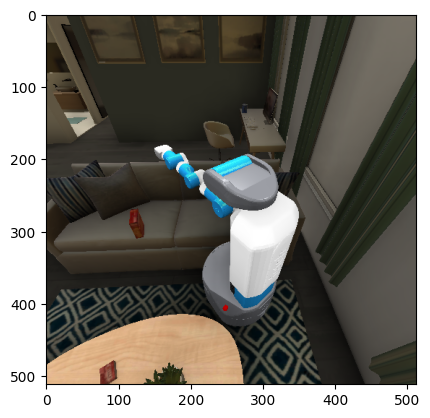

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# sim.reset()
art_agent = sim.articulated_agent
art_agent.sim_obj.motion_type = MotionType.KINEMATIC

receptacle_id = receptacle_ids[1]
target_receptacle = rom.get_object_by_id(receptacle_id)

base_receptacle_trans = target_receptacle.translation
print(target_receptacle.handle, "is in", base_receptacle_trans)

sample = sim.pathfinder.get_random_navigable_point_near(
    circle_center=base_receptacle_trans, radius=1.0, island_index=-1
)
vec_sample_obj = base_receptacle_trans - sample

angle_sample_obj = np.arctan2(-vec_sample_obj[2], vec_sample_obj[0])

sim.articulated_agent.base_pos = sample
sim.articulated_agent.base_rot = angle_sample_obj
print("robot is in",sim.articulated_agent.base_pos)

obs = sim.step({})

plt.imshow(obs["third_rgb"])

이 소파위에 이미 scene에 있는 물건과 scene에 없는 물건을 추가해보겠습니다.

003_cracker_box_:0005 is in Vector(-6.248, 0.989397, -5.501)
move added object to base position
robot position: Vector(-6.82517, 0.180179, -6.2597)


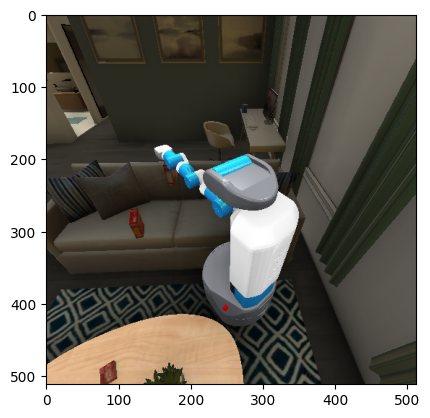

In [19]:
obj_templates_mgr = sim.get_object_template_manager()

# template_handle = obj_templates_mgr.get_template_handles("data/objects/ycb/configs")[30]
added_object = rom.duplicate_object_by_id(obj_ids[3])

added_object.translation = base_receptacle_trans + mn.Vector3(0,0.5,0)

print(added_object.handle, "is in", added_object.translation)

print("move added object to base position")
print("robot position:", sim.articulated_agent.base_pos)
obs = sim.step({})

plt.imshow(obs["third_rgb"])

017_orange_:0002 is in Vector(-6.148, 0.589397, -5.401)
move added object to base position
robot position: Vector(-6.82517, 0.180179, -6.2597)


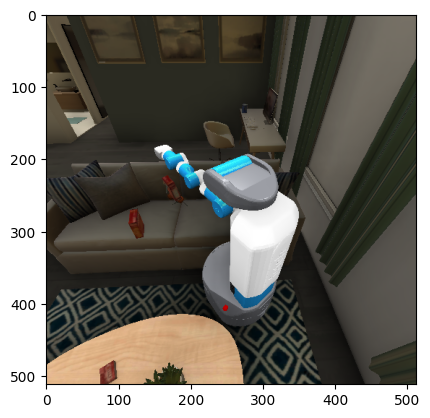

In [26]:

template_handle = obj_templates_mgr.get_template_handles("data/objects/ycb/configs")[15]
added_object_2 = rom.add_object_by_template_handle(template_handle)

added_object_2.translation = base_receptacle_trans + mn.Vector3(0.1,0.1,0.1)

print(added_object_2.handle, "is in", added_object_2.translation)

print("move added object to base position")
print("robot position:", sim.articulated_agent.base_pos)
obs = sim.step({})

plt.imshow(obs["third_rgb"])

엄밀한 code는 single_sample, ReceptacleTracker, ReceptacleSet을 참고하면 될듯 함